<a href="https://colab.research.google.com/github/LarsBentsen/CourseDSAIStatisticalLearning/blob/main/testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting House Prices

In [148]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression, SGDRegressor, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Load the California Housing Dataset

In [149]:
df = pd.read_csv('https://github.com/LarsBentsen/CourseDSAIStatisticalLearning/blob/main/data/California_Housing.txt?raw=true')
print("number of rows: ", df.shape[0])
df.head()

number of rows:  20640


longitude  latitude  housingMedianAge  totalRooms  totalBedrooms  \
0    -122.23     37.88              41.0       880.0          129.0   
1    -122.22     37.86              21.0      7099.0         1106.0   
2    -122.24     37.85              52.0      1467.0          190.0   
3    -122.25     37.85              52.0      1274.0          235.0   
4    -122.25     37.85              52.0      1627.0          280.0   

   population  households  medianIncome  medianHouseValue  
0       322.0       126.0        8.3252          452600.0  
1      2401.0      1138.0        8.3014          358500.0  
2       496.0       177.0        7.2574          352100.0  
3       558.0       219.0        5.6431          341300.0  
4       565.0       259.0        3.8462          342200.0

In [150]:
# rename columns to be consistent with the book
df.rename(columns={
    'population': 'Population',
    'housingMedianAge': 'HouseAge',
    'longitude': 'Longitude',
    'latitude': 'Latitude',
    'medianIncome': 'MedInc',
    'medianHouseValue': 'MedHouseVal'}, inplace=True)
df['MedHouseVal'] /= 100000

# calculate average values from total values
df['AveBedrms'] = df['totalBedrooms'] / df['households']
df['AveRooms'] = df['totalRooms'] / df['households']
df['AveOccup'] = df['Population'] / df['households']

# The response variable Y is the median house value in each
# neighborhood measured in units of $100,000.
target = 'MedHouseVal'

features = ['Population', 'AveBedrms', 'AveRooms', 'HouseAge',
            'Latitude', 'AveOccup', 'Longitude', 'MedInc']

In [151]:
# check missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Longitude      20640 non-null  float64
 1   Latitude       20640 non-null  float64
 2   HouseAge       20640 non-null  float64
 3   totalRooms     20640 non-null  float64
 4   totalBedrooms  20640 non-null  float64
 5   Population     20640 non-null  float64
 6   households     20640 non-null  float64
 7   MedInc         20640 non-null  float64
 8   MedHouseVal    20640 non-null  float64
 9   AveBedrms      20640 non-null  float64
 10  AveRooms       20640 non-null  float64
 11  AveOccup       20640 non-null  float64
dtypes: float64(12)
memory usage: 1.9 MB


## Plot the correlation matrix to get a sense of the linear correlation between features

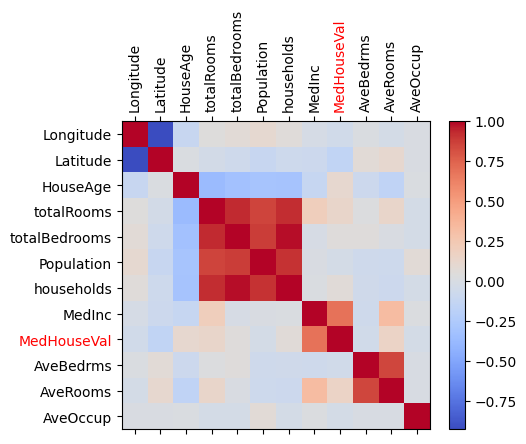

In [152]:
corr = df.corr()
# Plot the correlation matrix
fig, ax = plt.subplots(figsize=(5, 4))
cax = ax.matshow(corr, cmap='coolwarm')

# Add color bar
plt.colorbar(cax)

# Set ticks and labels
ax.set_xticks(np.arange(len(corr.columns)))
ax.set_yticks(np.arange(len(corr.columns)))

ax.set_xticklabels(corr.columns, rotation=90)
ax.set_yticklabels(corr.columns)

# Customize the x-tick label for "MedHouseVal"
for label in ax.get_xticklabels():
    if label.get_text() == "MedHouseVal":
        label.set_color('red')

# Customize the y-tick label for "MedHouseVal"
for label in ax.get_yticklabels():
    if label.get_text() == "MedHouseVal":
        label.set_color('red')

# Show the plot
plt.show()

In [153]:
df.head()

Longitude  Latitude  HouseAge  totalRooms  totalBedrooms  Population  \
0    -122.23     37.88      41.0       880.0          129.0       322.0   
1    -122.22     37.86      21.0      7099.0         1106.0      2401.0   
2    -122.24     37.85      52.0      1467.0          190.0       496.0   
3    -122.25     37.85      52.0      1274.0          235.0       558.0   
4    -122.25     37.85      52.0      1627.0          280.0       565.0   

   households  MedInc  MedHouseVal  AveBedrms  AveRooms  AveOccup  
0       126.0  8.3252        4.526   1.023810  6.984127  2.555556  
1      1138.0  8.3014        3.585   0.971880  6.238137  2.109842  
2       177.0  7.2574        3.521   1.073446  8.288136  2.802260  
3       219.0  5.6431        3.413   1.073059  5.817352  2.547945  
4       259.0  3.8462        3.422   1.081081  6.281853  2.181467

In [154]:
df.describe()

Longitude      Latitude      HouseAge    totalRooms  totalBedrooms  \
count  20640.000000  20640.000000  20640.000000  20640.000000   20640.000000   
mean    -119.569704     35.631861     28.639486   2635.763081     537.898014   
std        2.003532      2.135952     12.585558   2181.615252     421.247906   
min     -124.350000     32.540000      1.000000      2.000000       1.000000   
25%     -121.800000     33.930000     18.000000   1447.750000     295.000000   
50%     -118.490000     34.260000     29.000000   2127.000000     435.000000   
75%     -118.010000     37.710000     37.000000   3148.000000     647.000000   
max     -114.310000     41.950000     52.000000  39320.000000    6445.000000   

         Population    households        MedInc   MedHouseVal     AveBedrms  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean    1425.476744    499.539680      3.870671      2.068558      1.096675   
std     1132.462122    382.329753      1.899822      1.153956      0.473911   
min        3.000000      1.000000      0.499900      0.149990      0.333333   
25%      787.000000    280.000000      2.563400      1.196000      1.006079   
50%     1166.000000    409.000000      3.534800      1.797000      1.048780   
75%     1725.000000    605.000000      4.743250      2.647250      1.099526   
max    35682.000000   6082.000000     15.000100      5.000010     34.066667   

           AveRooms      AveOccup  
count  20640.000000  20640.000000  
mean       5.429000      3.070655  
std        2.474173     10.386050  
min        0.846154      0.692308  
25%        4.440716      2.429741  
50%        5.229129      2.818116  
75%        6.052381      3.282261  
max      141.909091   1243.333333

<Figure size 500x500 with 0 Axes>

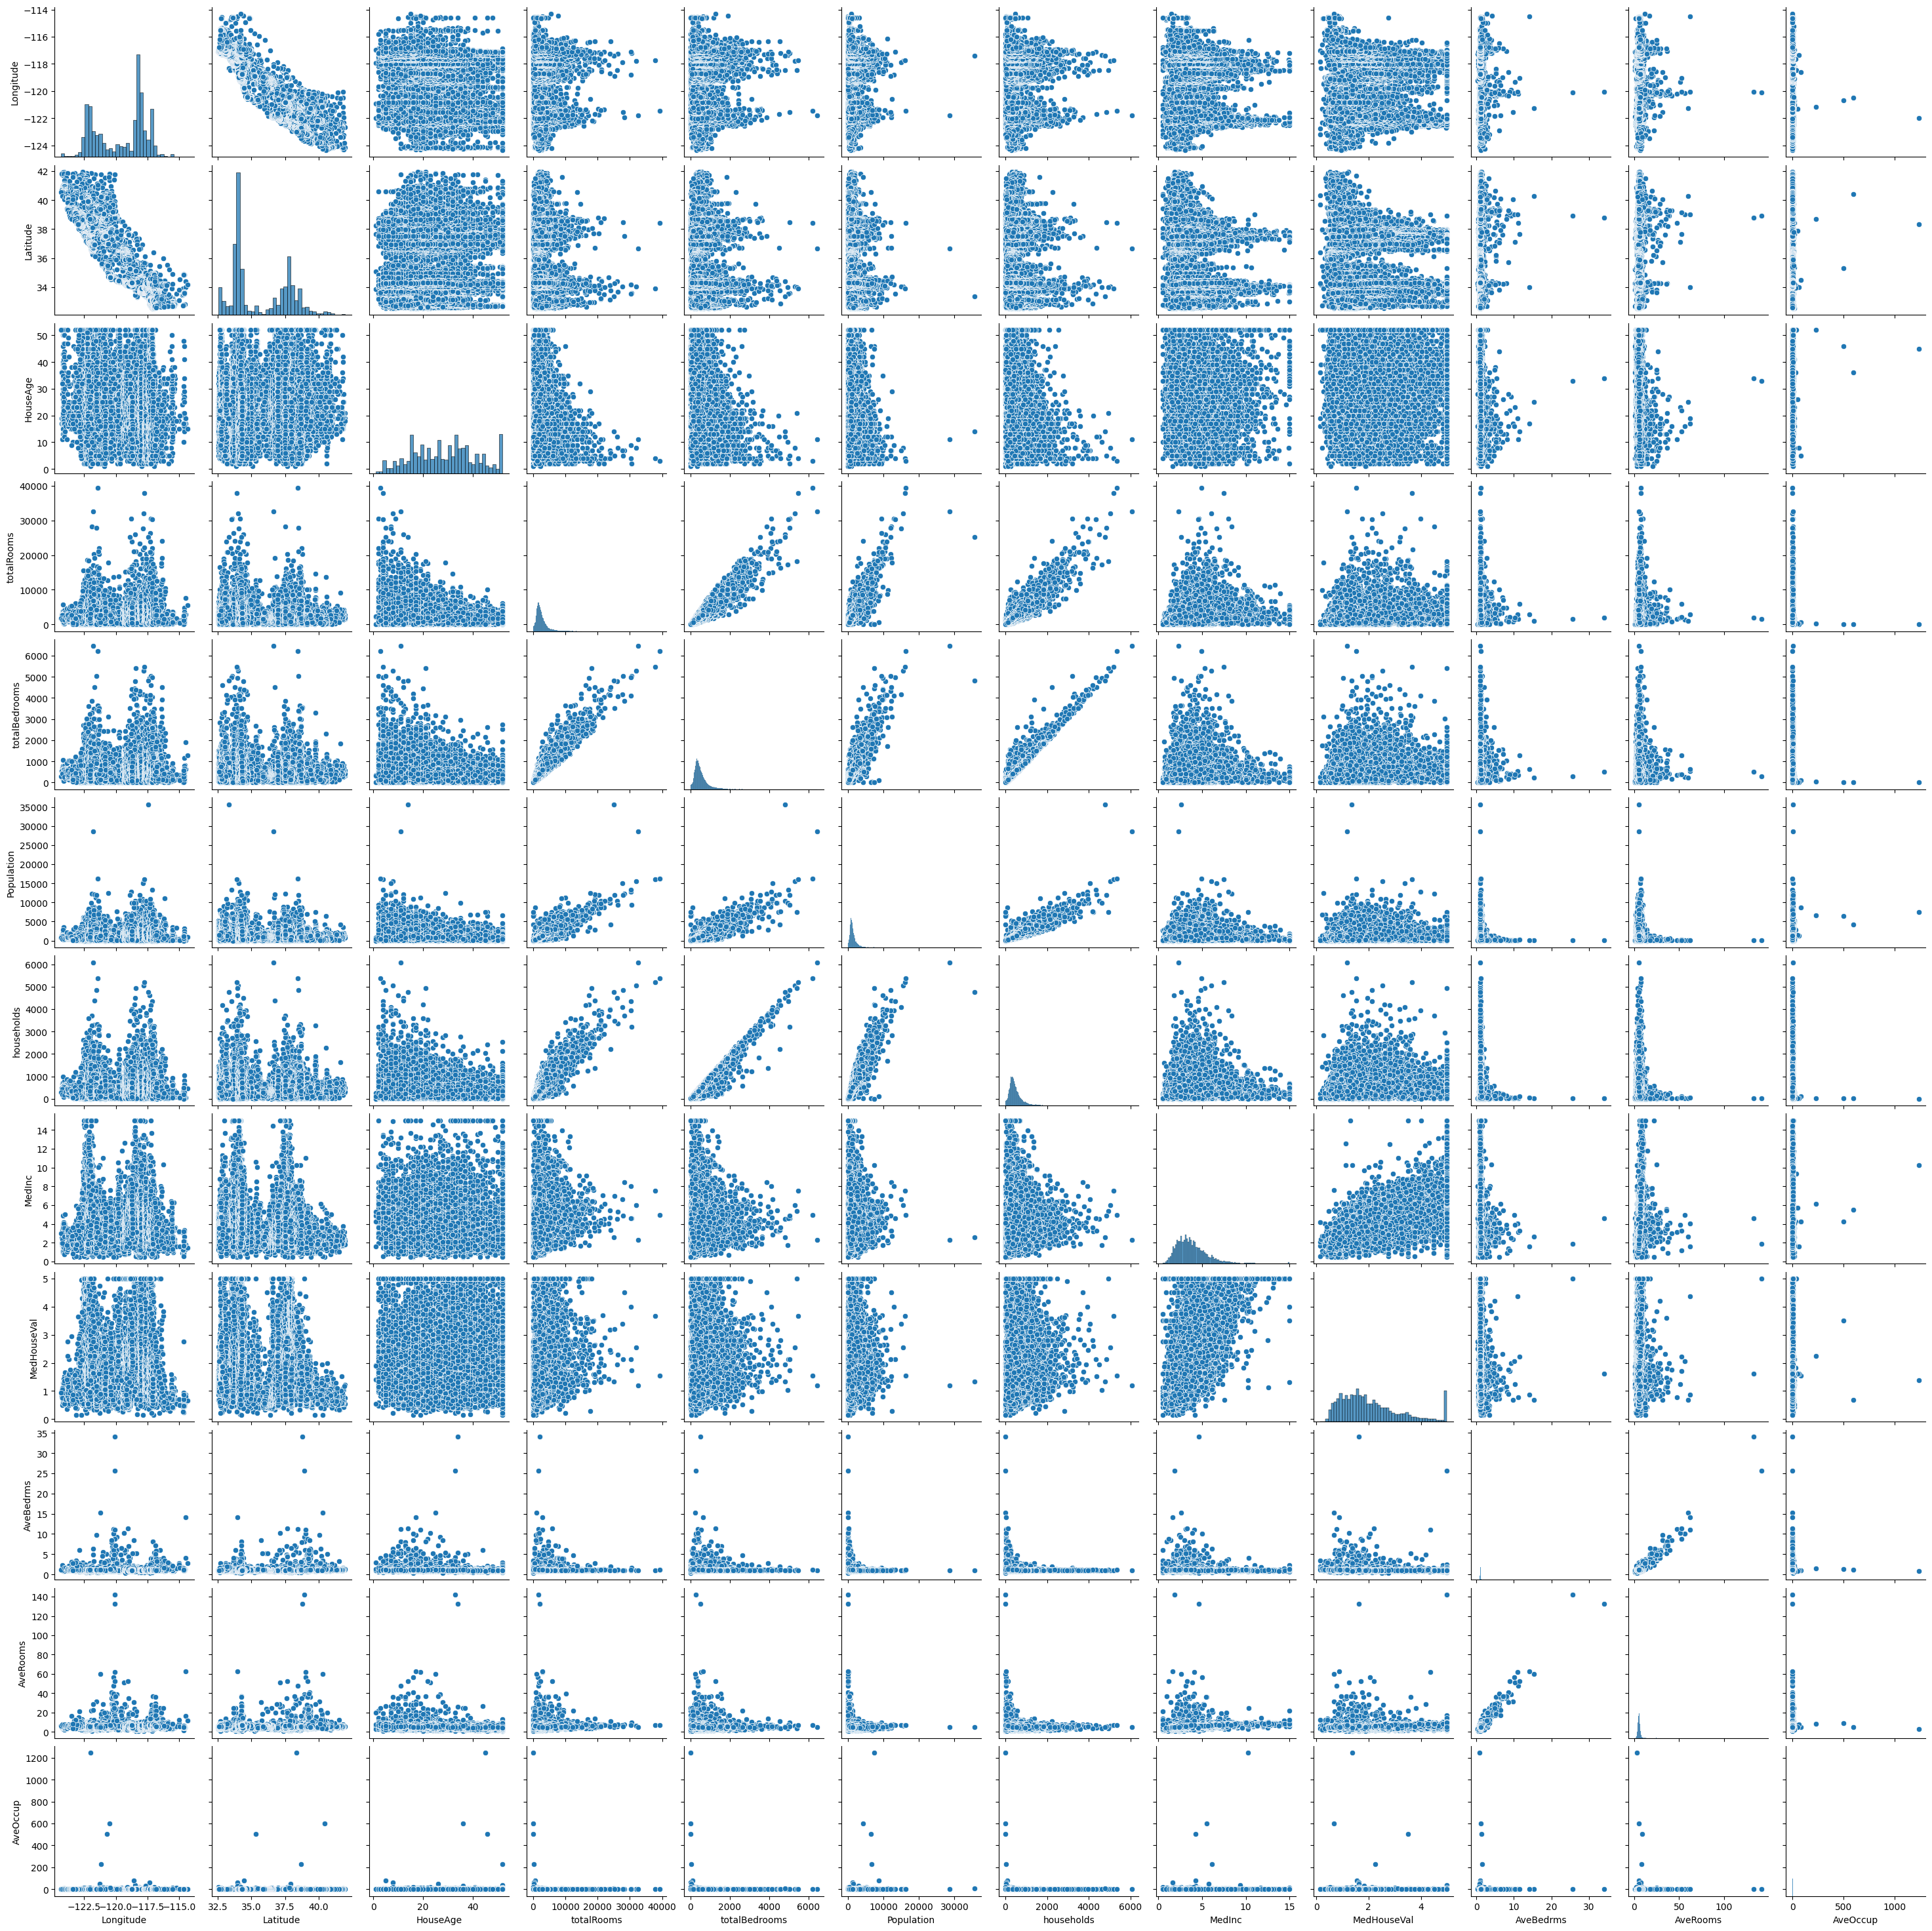

In [155]:
# Scatter plots of the features against each other and histograms of the features
plt.figure(figsize=(5,5))
sns.pairplot(df)
plt.show()

## Data preperation

Before model training, data needs to be prepared to be suitable for further model training and analysis

### Longitude
Example with one feature. Check distribution and correlation with target feature. Will decide if this column can be dropped. 

In [156]:
df['Longitude'].describe()

count    20640.000000
mean      -119.569704
std          2.003532
min       -124.350000
25%       -121.800000
50%       -118.490000
75%       -118.010000
max       -114.310000
Name: Longitude, dtype: float64

/var/folders/g5/pxwbq80j14jfslh66f7t4p2h0000gp/T/ipykernel_11066/1923326972.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=df['Longitude'], bins=10, palette='viridis', kde=True)


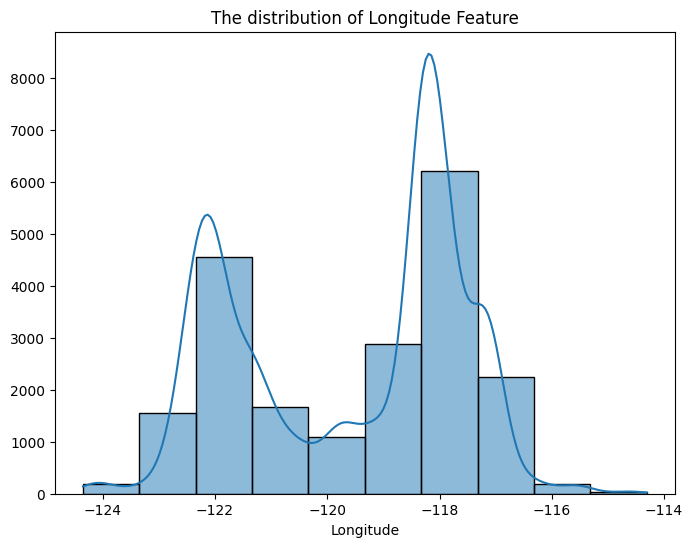

In [157]:
plt.figure(figsize=(8,6))
sns.histplot(x=df['Longitude'], bins=10, palette='viridis', kde=True)
plt.title("The distribution of Longitude Feature")
plt.ylabel("")
plt.show()

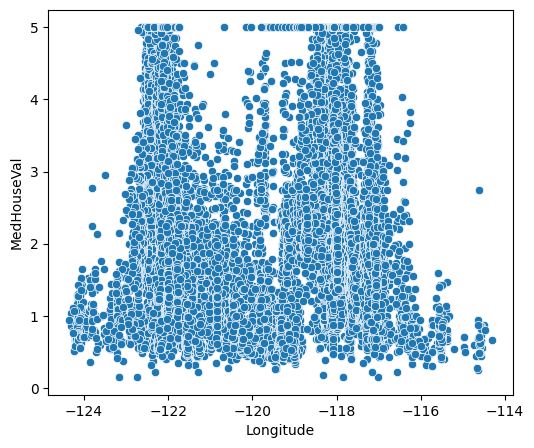

In [158]:
# Check the correlation between the feature and response (median house value)
# Longitude does not contain any useful information for median house value
plt.figure(figsize=(6,5))
sns.scatterplot(x=df['Longitude'], y=df['MedHouseVal']);

### Average of total rooms

In [159]:
df['AveBedrms'].describe()

count    20640.000000
mean         1.096675
std          0.473911
min          0.333333
25%          1.006079
50%          1.048780
75%          1.099526
max         34.066667
Name: AveBedrms, dtype: float64

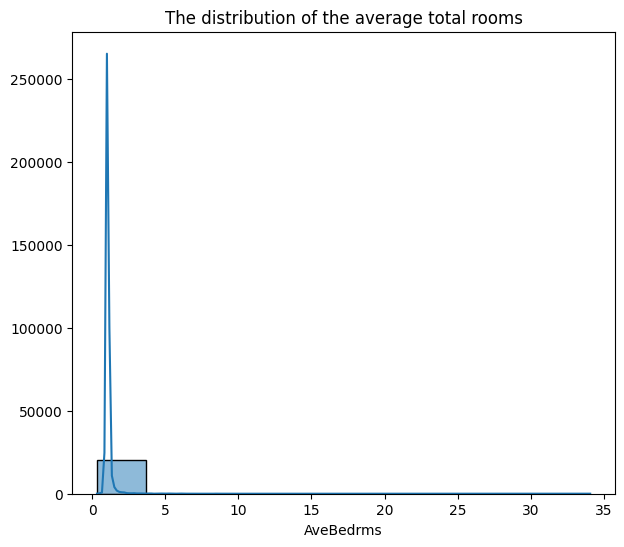

In [160]:
plt.figure(figsize=(7,6))
sns.histplot(x=df['AveBedrms'], bins=10, kde=True)
plt.title("The distribution of the average total rooms")
plt.ylabel("")
plt.show()

Strong right-skewed feature.
Check possible outliers

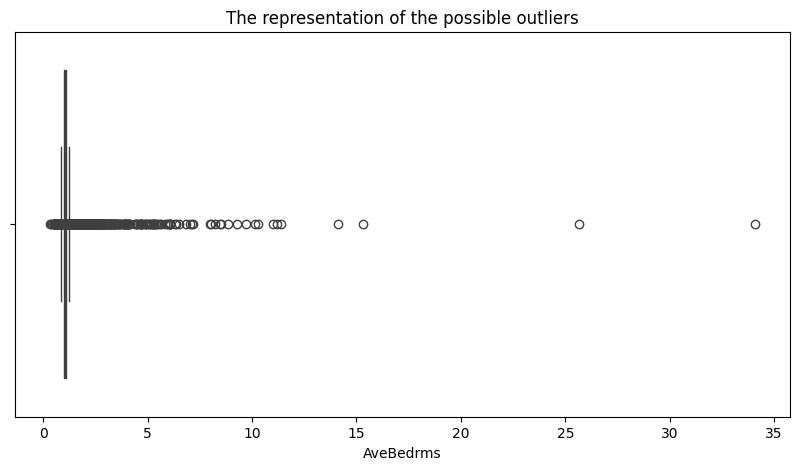

In [161]:
plt.figure(figsize=(10,5))
sns.boxplot(x=df['AveBedrms'])
plt.title("The representation of the possible outliers")
plt.show()

Many possible outliers. Choose a threshold to filter them out.
Test with the 95th percentile

In [162]:
perc_99 = np.percentile(df['AveBedrms'], 99)
print(f'99th Percentile Value: {perc_99}')
outliers = (df['AveBedrms']>perc_99).sum()
print(f'Number of Potential Outliers: {outliers}')
print(f"The max value is {np.max(df['AveBedrms'])}")

99th Percentile Value: 2.127540822838997
Number of Potential Outliers: 207
The max value is 34.06666666666667


In [163]:
# drop values above the 95th percentile
df.drop(df[df['AveBedrms']>perc_99].index, axis=0, inplace=True)

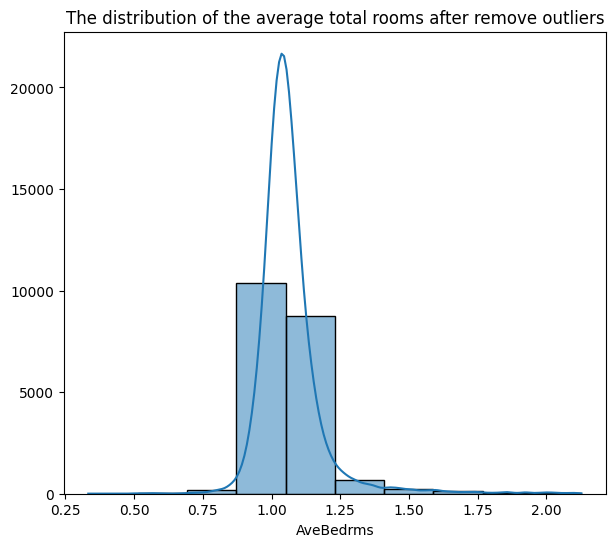

In [164]:
# check distribution
plt.figure(figsize=(7,6))
sns.histplot(x=df['AveBedrms'], bins=10, kde=True)
plt.title("The distribution of the average total rooms after remove outliers")
plt.ylabel("")
plt.show()

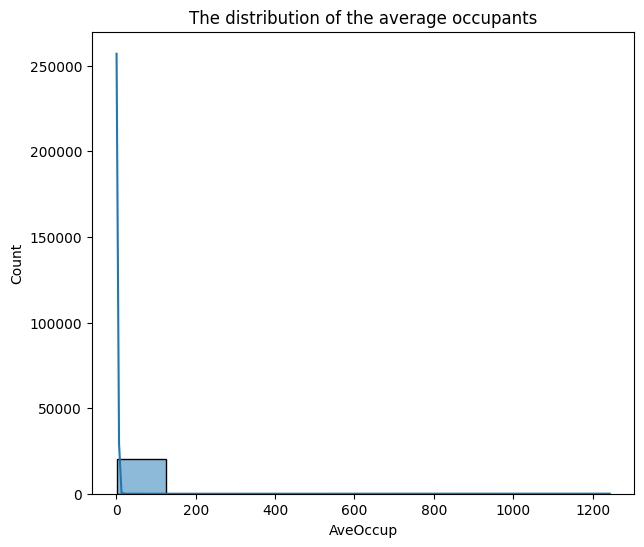

In [165]:
# check distribution
plt.figure(figsize=(7,6))
sns.histplot(x=df['AveOccup'], bins=10, kde=True)
plt.title("The distribution of the average occupants")
plt.show()

In [166]:
perc_99 = np.percentile(df['AveOccup'], 99)
print(f'95th Percentile Value: {perc_99}')
outliers = (df['AveOccup']>perc_99).sum()
print(f'Number of Potential Outliers: {outliers}')
print(f"The max value is {np.max(df['AveOccup'])}")

95th Percentile Value: 5.395025257452575
Number of Potential Outliers: 205
The max value is 1243.3333333333333


In [167]:
# drop values above the 95th percentile
df.drop(df[df['AveOccup']>perc_99].index, axis=0, inplace=True)

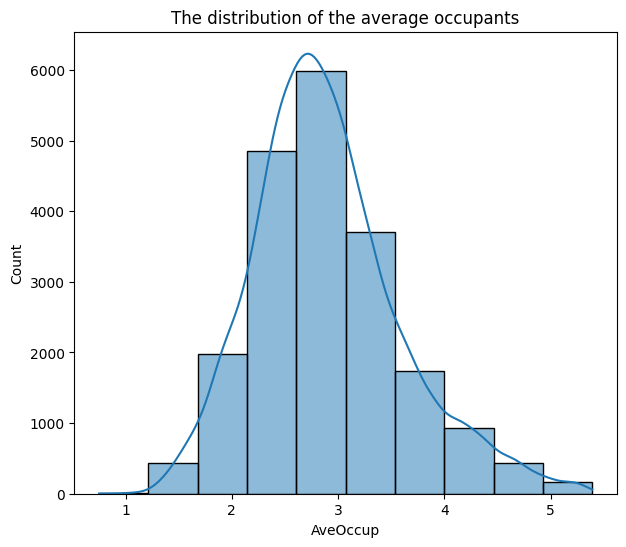

In [168]:
# check distribution
plt.figure(figsize=(7,6))
sns.histplot(x=df['AveOccup'], bins=10, kde=True)
plt.title("The distribution of the average occupants")
plt.show()

Feature is now more normally distributed. Ideally you want to do this for all the columns, but will be skipped here for brevity... 

# Model training

In [169]:
# Split Test/Train
# Set the seed (so that we all get the same results)
np.random.seed(666)
test_indxs = np.random.choice(np.arange(df.shape[0]), size=df.shape[0] // 5, replace=False)
df_test = df.iloc[test_indxs]
df = df.drop(df.index[test_indxs])

In [170]:
# Start with the simplest model - linear regression

# divide target value from features
X_train = df[features]
y_train = df[target]

X_test = df_test[features]
y_test = df_test[target]

lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [171]:
# Model evaluation
print(f"Train Accuracy:{lr.score(X_train,y_train)}")        # i.e. R2 score
print(f"Test Accuracy:{lr.score(X_test,y_test)}")

y_pred = lr.predict(X_test)
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred)}")
print(f"R2 Score: {r2_score(y_test, y_pred)}")

Train Accuracy:0.6708376661426285
Test Accuracy:0.6717268505430547
Mean Squared Error: 0.43869310223173
Mean Absolute Error: 0.48761212024372125
R2 Score: 0.6717268505430547


In [172]:
mean_squared_error(y_train,  lr.predict(X_train))

0.44040738483792685

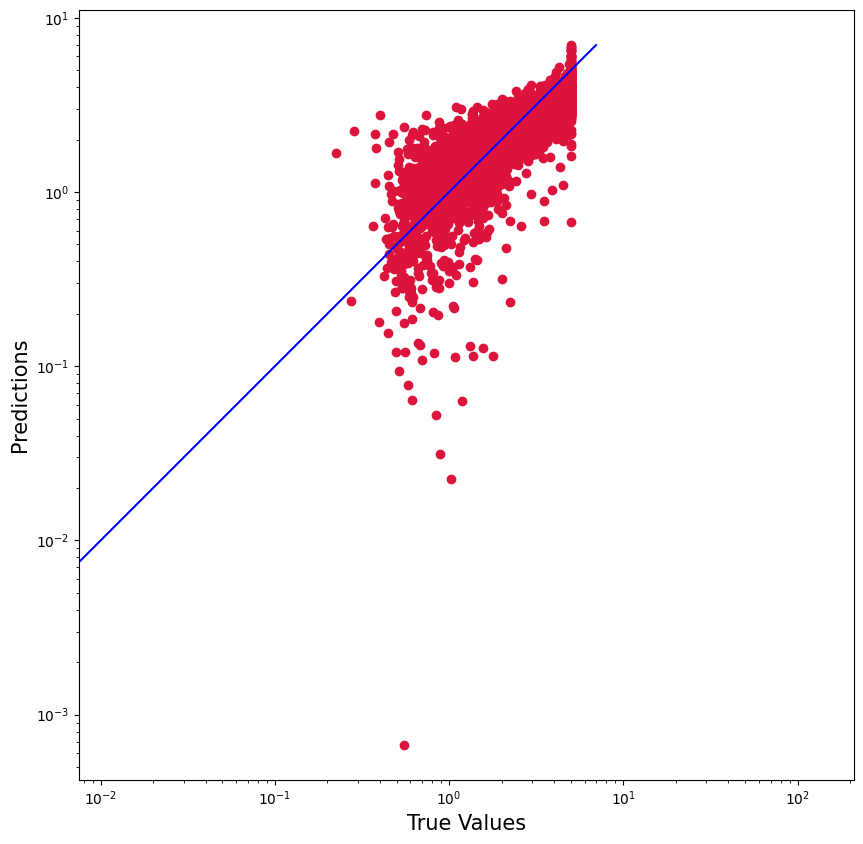

In [173]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

0.44040738483792685
0.48811541683588244


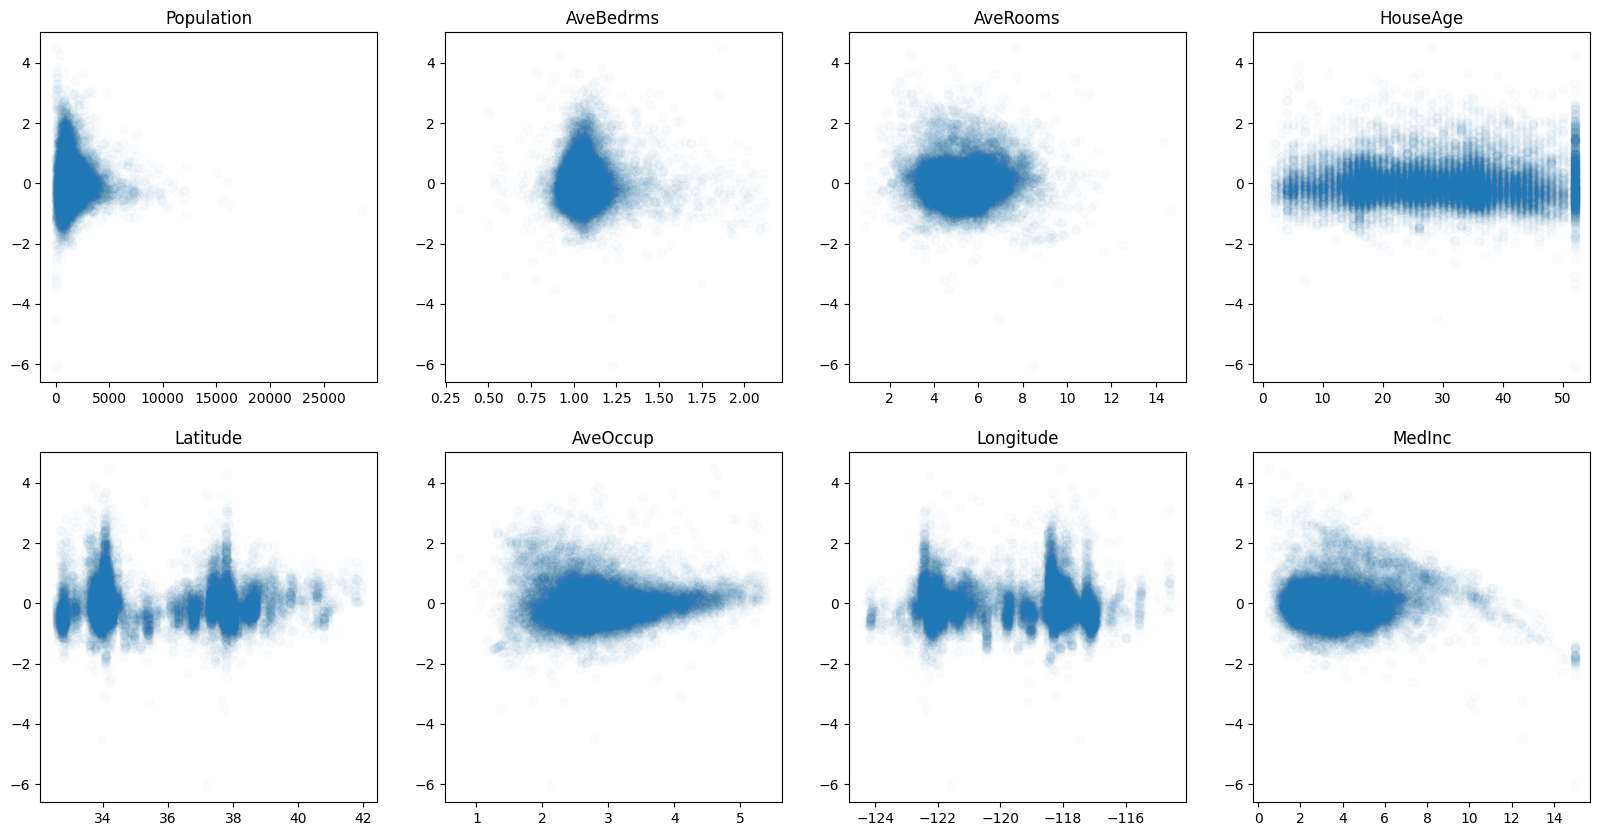

In [204]:

lr = LinearRegression()
lr.fit(X_train,y_train)

fig, axs = plt.subplots(2, int(np.ceil(len(features)/2)), figsize=(20, 10))
axs = axs.flatten()
for i, f_i in enumerate(features):
    axs[i].set_title(f_i)
    axs[i].scatter(X_train[f_i], y_train.values - lr.predict(X_train), alpha=0.02)

In [175]:
# Define the models and their parameter grids for tuning
param_grid_lasso = {'alpha': np.logspace(-4, 4, 50)}
param_grid_ridge = {'alpha': np.logspace(-4, 4, 50)}

# Define 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize GridSearchCV for Lasso and Ridge
lasso_cv = GridSearchCV(Lasso(), param_grid_lasso, cv=kf, scoring='neg_mean_squared_error')
ridge_cv = GridSearchCV(Ridge(), param_grid_ridge, cv=kf, scoring='neg_mean_squared_error')

# Fit the models
lasso_cv.fit(X_train, y_train)
ridge_cv.fit(X_train, y_train)

# Print the best parameters and corresponding scores
print(f"Best Lasso alpha: {lasso_cv.best_params_['alpha']}")
print(f"Best Lasso MSE: {-lasso_cv.best_score_}")

print(f"Best Ridge alpha: {ridge_cv.best_params_['alpha']}")
print(f"Best Ridge MSE: {-ridge_cv.best_score_}")

# Optionally, fit the models on the entire dataset with the best found parameters
best_lasso = Lasso(alpha=lasso_cv.best_params_['alpha']).fit(X_train, y_train)
best_ridge = Ridge(alpha=ridge_cv.best_params_['alpha']).fit(X_train, y_train)

print(f"Best Lasso model coefficients: {best_lasso.coef_}")
print(f"Best Ridge model coefficients: {best_ridge.coef_}")

Best Lasso alpha: 0.0001
Best Lasso MSE: 0.44108698987721306
Best Ridge alpha: 0.8286427728546842
Best Ridge MSE: 0.4410857643266099
Best Lasso model coefficients: [ 4.21829678e-05  1.04964583e+00 -1.02033455e-01  1.11195206e-02
 -4.39746737e-01 -3.93936238e-01 -4.26577388e-01  4.30172420e-01]
Best Ridge model coefficients: [ 4.21737258e-05  1.05484796e+00 -1.02466423e-01  1.11183694e-02
 -4.39922597e-01 -3.93938392e-01 -4.26792561e-01  4.30422987e-01]


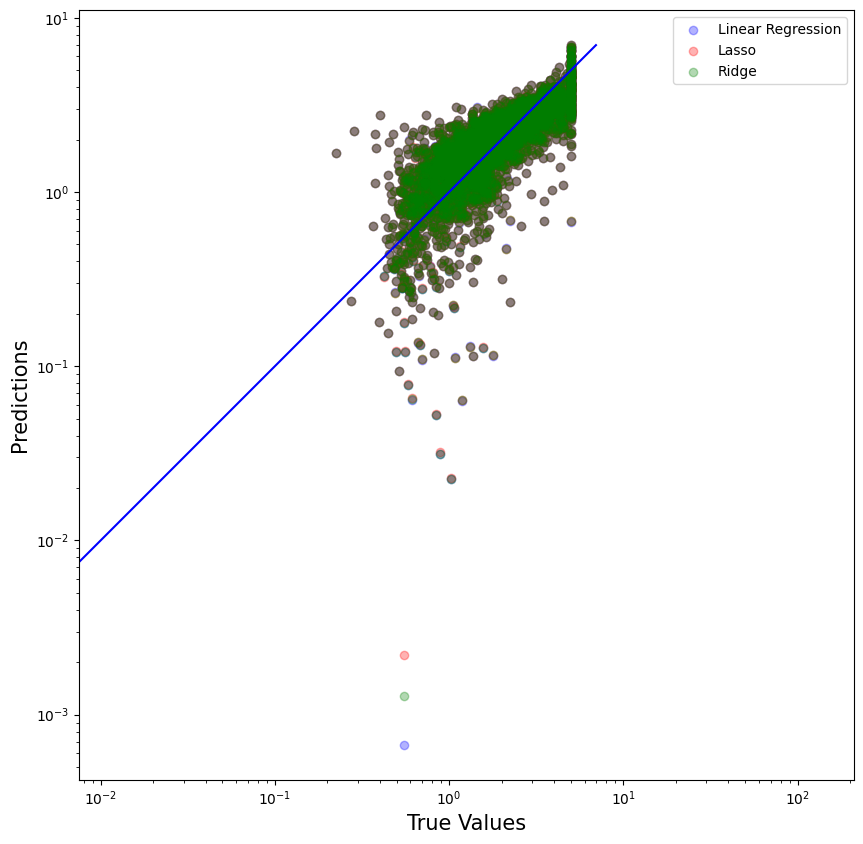

               Model  Train MSE  Test MSE  Test MAE   Test R2
0  Linear Regression   0.440407  0.438693  0.487612  0.671727
1              Lasso   0.440409  0.438665  0.487612  0.671748
2              Ridge   0.440408  0.438679  0.487616  0.671737


In [176]:

# Make predictions with all models
y_pred_lr = LinearRegression().fit(X_train, y_train).predict(X_test)
y_pred_lasso = best_lasso.predict(X_test)
y_pred_ridge = best_ridge.predict(X_test)


# Plot predictions
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred_lr, c='blue', label='Linear Regression', alpha=0.3)
plt.scatter(y_test, y_pred_lasso, c='red', label='Lasso', alpha=0.3)
plt.scatter(y_test, y_pred_ridge, c='green', label='Ridge', alpha=0.3)
plt.yscale('log')
plt.xscale('log')
p1 = max(max(y_pred_lr), max(y_test))
p2 = min(min(y_pred_lr), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.legend()
plt.show()

# Model evaluation
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": best_lasso,
    "Ridge": best_ridge
}


results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    train_mse = mean_squared_error(y_train, model.predict(X_train))
    test_mse = mean_squared_error(y_test, model.predict(X_test))
    test_mae = mean_absolute_error(y_test, model.predict(X_test))
    test_r2 = r2_score(y_test, model.predict(X_test))
    results.append({'Model': name, 'Train MSE': train_mse, 'Test MSE': test_mse, 
                    'Test MAE': test_mae, 'Test R2': test_r2})

results_df = pd.DataFrame(results)
print(results_df)

# Your turn: 

1. Can we improve the preprocessing of the data? Try to investigate the other features to see if you can find any other columns with significant outliers. 
2. Can you improve performance by trying to avoid heteroscedastic errors? 
    - Are there any trends in the residuals or residual variance? 
3. Is a more advanced model maybe required? Maybe try a boosting model, SVR or MLP? 